In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os
import re

# Data inspection and cleaning

In [139]:
server_ips = pd.read_csv("servers_ips.csv")
websites_info = pd.read_csv("websites_info.csv")
DE = pd.read_csv("DE_status_codes.csv")
FR = pd.read_csv("FR_status_code_counts.csv")
LT = pd.read_csv("LT_status_codes.csv")
NO = pd.read_csv("NO_status_codes.csv")
SE = pd.read_csv("SE_status_codes.csv")
ZA = pd.read_csv("ZA_status_codes.csv")

In [140]:
datasets = {
    "server_ips": server_ips,
    "websites_info": websites_info,
    "DE_status_codes": DE,
    "FR_status_code_counts": FR,
    "LT_status_codes": LT,
    "NO_status_codes": NO,
    "SE_status_codes": SE,
    "ZA_status_codes": ZA
}

for name, df in datasets.items():
    print(f"{name}: {df.shape}")


server_ips: (6562, 4)
websites_info: (3652, 4)
DE_status_codes: (3995, 13)
FR_status_code_counts: (4210, 14)
LT_status_codes: (4035, 12)
NO_status_codes: (4320, 13)
SE_status_codes: (4939, 15)
ZA_status_codes: (4310, 17)


In [141]:
websites_info.head()

,Unnamed: 0,website,category,is_in_top_1000_website_list
0,0,https://notion.so,Computers_Electronics_and_Technology,True
1,1,https://021.rs,News_and_Media,False
2,2,https://discogs.com,Arts_and_Entertainment,True
3,3,https://ancestry.com,Hobbies_and_Leisure,True
4,4,https://instagram.com,Computers_Electronics_and_Technology,True


In [142]:
websites_info = websites_info.drop(columns=["Unnamed: 0"])
websites_info.sample(10)

,website,category,is_in_top_1000_website_list
591,https://dw.com,News_and_Media,True
933,https://uib.no,Science_and_Education,False
3502,themarker.com,Finance,False
2480,https://myclip.vn,Arts_and_Entertainment,False
75,https://google.ru,Computers_Electronics_and_Technology,True
3143,evz.ro,News_and_Media,False
515,https://mozzartbet.com,Sports,False
2393,https://agones.gr,Sports,False
423,https://swisscom.ch,Computers_Electronics_and_Technology,False
1284,https://3bmeteo.com,Science_and_Education,True


In [143]:
def clean_website_to_brand(url):
    if pd.isna(url):
        return ""

    url = str(url).strip().lower()
    url = re.sub(r'^https?://', '', url)
    url = re.sub(r'^www\.', '', url)
    url = url.split('/')[0]

    # take only part before first dot
    brand = url.split('.')[0]

    return brand


tables = [websites_info]
for df in tables:
    df['brand'] = df['website'].apply(clean_website_to_brand)

brand_category_counts = (
    websites_info
    .groupby('brand')['category']
    .nunique()
    .sort_values(ascending=False)
)

# show only brands with more than 1 category
brand_category_counts[brand_category_counts > 1]

brand
google        3
a1            3
sport         3
carousell     2
laposte       2
alo           2
bestbuy       2
gmx           2
go            2
finance       2
gazzetta      2
facebook      2
bt            2
alza          2
blog          2
gov           2
gva           2
ica           2
dmm           2
buienradar    2
detik         2
lidl          2
livedoor      2
health        2
football      2
centrum       2
capital       2
dpgmedia      2
flashscore    2
mega          2
met           2
meteo         2
money         2
news          2
nike          2
nova          2
o2            2
one           2
op            2
pobre         2
ria           2
edu           2
sports        2
startpage     2
sun           2
t-online      2
telegram      2
tempo         2
tiscali       2
tsn           2
tubidy        2
unibet        2
visma         2
vodafone      2
wayfair       2
yandex        2
Name: category, dtype: int64

We can see, that the same websites could be assigned to multiple category, thus we need to unify it by choosing for each "brand" only one category type.

In [144]:
brand_to_category = (
    websites_info
    .groupby('brand')['category']
    .agg(lambda x: x.value_counts().index[0])
    .to_dict()
)

websites_info['category_fixed'] = websites_info['brand'].map(brand_to_category)
websites_info.sample(20)

,website,category,is_in_top_1000_website_list,brand,category_fixed
1482,https://seb.se,Finance,False,seb,Finance
1722,https://xxxlutz.at,Home_and_Garden,False,xxxlutz,Home_and_Garden
1126,https://ogone.com,Finance,False,ogone,Finance
3544,wayfair.com,E-commerce_and_Shopping,True,wayfair,E-commerce_and_Shopping
1357,https://tiscali.it,News_and_Media,False,tiscali,Games
634,https://pch.com,Games,True,pch,Games
2662,https://opera.com,Computers_Electronics_and_Technology,True,opera,Computers_Electronics_and_Technology
2270,https://soccerladuma.co.za,Sports,False,soccerladuma,Sports
3625,nordea.se,Finance,False,nordea,Finance
2851,https://vivitusuerte.com,Gambling,False,vivitusuerte,Gambling


In [145]:
websites_info['website'] = websites_info['website'].astype(str).str.strip()

web_all_dupes = websites_info.duplicated(keep=False)
print("Websites info - duplicates (all columns):", web_all_dupes.sum())

web_website_dupes = websites_info.duplicated(subset=['website'], keep=False)
print("Websites info - duplicates (website only):", web_website_dupes.sum())

Websites info - duplicates (all columns): 0
Websites info - duplicates (website only): 0


In [146]:
server_ips.head()

,Unnamed: 0,country,server,ip
0,0,DE,de1079.nordvpn.com,5.180.61.174
1,1,DE,de1079.nordvpn.com,5.180.61.178
2,2,DE,de1079.nordvpn.com,194.233.96.82
3,3,DE,de1079.nordvpn.com,5.180.61.179
4,4,DE,de1079.nordvpn.com,194.233.96.84


In [147]:
server_ips = server_ips.drop(columns=["Unnamed: 0"])
server_ips.sample(10)

,country,server,ip
2422,FR,fr866.nordvpn.com,185.222.240.90
5736,SE,se543.nordvpn.com,185.219.140.65
5287,NO,no209.nordvpn.com,82.180.144.41
5837,SE,se399.nordvpn.com,37.120.209.213
3855,FR,fr853.nordvpn.com,185.234.71.184
6053,LT,lt14.nordvpn.com,45.82.33.144
1023,DE,de1073.nordvpn.com,194.233.96.40
4241,FR,fr592.nordvpn.com,160.238.38.237
3332,FR,fr777.nordvpn.com,31.187.73.76
3569,FR,fr803.nordvpn.com,185.234.70.94


In [149]:
server_ips['ip'] = server_ips['ip'].astype(str).str.strip()

server_all_dupes = server_ips.duplicated(keep=False)
print("Server IPs - duplicates (all columns):", server_all_dupes.sum())

server_ip_dupes = server_ips.duplicated(subset=['ip'], keep=False)
print("Server IPs - duplicates (ip only):", server_ip_dupes.sum())

Server IPs - duplicates (all columns): 0
Server IPs - duplicates (ip only): 0


In [150]:
DE.head()

,website,ip,200,503,0,404,429,403,502,475,202,400,504
0,https://office365.com,146.70.62.244,5,0,0,0,0,0,0,0,0,0,0
1,https://office365.com,159.48.53.100,5,0,0,0,0,0,0,0,0,0,0
2,https://office365.com,146.70.62.228,4,0,0,0,0,0,0,0,0,0,0
3,https://office365.com,146.70.62.229,4,0,0,0,0,0,0,0,0,0,0
4,https://office365.com,146.70.62.237,4,0,0,0,0,0,0,0,0,0,0


In [151]:
FR.head()


,website,ip,200,404,0,475,502,500,403,503,504,400,511,302
0,https://novinky.cz,138.199.16.10,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,https://novinky.cz,138.199.16.13,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,https://novinky.cz,138.199.16.14,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,https://novinky.cz,138.199.16.15,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,https://novinky.cz,138.199.16.178,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
LT.head()

,website,ip,200,0,302,404,403,503,400,502,475,504
0,https://nab.com.au,185.65.50.103,3,0,0,0,0,0,0,0,0,0
1,https://nab.com.au,185.65.50.105,3,0,0,0,0,0,0,0,0,0
2,https://nab.com.au,185.65.50.100,2,0,0,0,0,0,0,0,0,0
3,https://nab.com.au,185.65.50.101,2,0,0,0,0,0,0,0,0,0
4,https://nab.com.au,185.65.50.102,2,0,0,0,0,0,0,0,0,0


In [153]:
NO.head()

,website,ip,200,0,403,429,206,503,404,500,475,400,302
0,https://adp.com,146.70.17.140,8,0,0,0,0,0,0,0,0,0,0
1,https://adp.com,146.70.17.141,8,0,0,0,0,0,0,0,0,0,0
2,https://adp.com,146.70.17.142,8,0,0,0,0,0,0,0,0,0,0
3,https://adp.com,146.70.17.164,8,0,0,0,0,0,0,0,0,0,0
4,https://adp.com,146.70.17.165,8,0,0,0,0,0,0,0,0,0,0


In [154]:
SE.head()

,website,ip,0,200,503,403,502,429,400,404,475,500,302,202,504
0,https://globo.com,185.219.140.10,4,4,0,0,0,0,0,0,0,0,0,0,0
1,https://globo.com,185.219.140.79,4,4,0,0,0,0,0,0,0,0,0,0,0
2,https://globo.com,185.219.140.80,4,4,0,0,0,0,0,0,0,0,0,0,0
3,https://globo.com,185.219.140.81,4,4,0,0,0,0,0,0,0,0,0,0,0
4,https://globo.com,185.219.140.82,4,4,0,0,0,0,0,0,0,0,0,0,0


In [155]:
ZA.head()

,website,ip,200,403,0,400,503,504,522,475,302,202,511,500,404,301,429
0,https://rottentomatoes.com,165.73.242.83,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,https://rottentomatoes.com,165.73.241.12,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,https://rottentomatoes.com,165.73.241.19,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,https://rottentomatoes.com,165.73.241.27,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,https://rottentomatoes.com,165.73.241.3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Each country dataset contains a different set of status code columns. This does not mean that monitoring checks differ; rather, it reflects that different HTTP responses were observed in each region.
To ensure consistent analysis, we take the union of all status code columns across countries and fill missing columns with zero. This preserves the correct total number of monitoring checks for each website–IP pair, while allowing us to compute comparable metrics such as success rate and error distribution.

In [156]:
status_tables = {
    "DE": DE,
    "FR": FR,
    "LT": LT,
    "NO": NO,
    "SE": SE,
    "ZA": ZA
}

for name, df in status_tables.items():
    all_dupes = df.duplicated(keep=False).sum() 
    key_dupes = df.duplicated(subset=["website", "ip"], keep=False).sum()
    
    print(f"--- {name} ---")
    print(f"Duplicates (all columns): {all_dupes}")
    print(f"Duplicates (website & ip): {key_dupes}\n")


--- DE ---
Duplicates (all columns): 0
Duplicates (website & ip): 0

--- FR ---
Duplicates (all columns): 0
Duplicates (website & ip): 0

--- LT ---
Duplicates (all columns): 0
Duplicates (website & ip): 0

--- NO ---
Duplicates (all columns): 0
Duplicates (website & ip): 0

--- SE ---
Duplicates (all columns): 0
Duplicates (website & ip): 0

--- ZA ---
Duplicates (all columns): 0
Duplicates (website & ip): 0



In [157]:
status_tables = {
    "DE": DE,
    "FR": FR,
    "LT": LT,
    "NO": NO,
    "SE": SE,
    "ZA": ZA
}

# Show value counts for the '0' column in each table
for name, df in status_tables.items():
    if '0' in df.columns:
        print(f"--- {name} : 0 column distribution ---")
        print(df['0'].value_counts(dropna=False)) 
        print()


--- DE : 0 column distribution ---
0
0    3908
4      34
1      25
5      17
3       7
2       4
Name: count, dtype: int64

--- FR : 0 column distribution ---
0
0.0    4090
8.0      51
1.0      25
2.0      10
4.0       9
3.0       9
6.0       5
7.0       5
5.0       4
NaN       2
Name: count, dtype: int64

--- LT : 0 column distribution ---
0
0    3960
2      33
1      28
3      14
Name: count, dtype: int64

--- NO : 0 column distribution ---
0
0    4190
8      43
1      40
2      17
4      10
7       9
6       4
3       4
5       3
Name: count, dtype: int64

--- SE : 0 column distribution ---
0
0    4818
1      42
8      34
2      13
7      10
4       9
3       5
6       5
5       3
Name: count, dtype: int64

--- ZA : 0 column distribution ---
0
0    4176
4      50
1      32
2      23
5      19
3      10
Name: count, dtype: int64



Column "0" has different count values, and after clarification it marks "No response" thus we keep this column in order not to ruin total number of checks. 

In [158]:
status_tables = [
    ("DE", DE),
    ("FR", FR),
    ("LT", LT),
    ("NO", NO),
    ("SE", SE),
    ("ZA", ZA)
]

# Add a 'country' column to each table before union
tables_with_country = []
for country, df in status_tables:
    df_copy = df.copy()       
    df_copy['status_code_country'] = country
    tables_with_country.append(df_copy)

all_status_codes = pd.concat(tables_with_country, ignore_index=True, sort=True)
all_status_codes['website'] = all_status_codes['website'].astype(str).str.strip()

print(all_status_codes.shape)
all_status_codes.sample(10)

(25809, 20)


,0,200,202,206,301,302,400,403,404,429,475,500,502,503,504,511,522,ip,status_code_country,website
13852,0.0,8,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,146.70.17.142,NO,https://freepik.com
18410,0.0,8,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,185.219.140.10,SE,https://vrbo.com
12859,0.0,8,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,146.70.17.165,NO,https://aol.com
29,0.0,4,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,146.70.62.229,DE,https://kth.se
8480,0.0,0,NaN,NaN,NaN,3.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,185.65.50.109,LT,https://t.me
19707,0.0,8,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,185.219.140.80,SE,https://kaufland.de
2116,0.0,5,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,159.48.53.100,DE,https://newsnow.co.uk
5073,0.0,0,NaN,NaN,NaN,0.0,0.0,8.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,138.199.16.15,FR,https://leroymerlin.fr
25668,0.0,4,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,165.73.242.83,ZA,https://expedia.com
4363,0.0,8,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,138.199.16.15,FR,https://francetvinfo.fr


In [159]:
all_status_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25809 entries, 0 to 25808
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   0                    25807 non-null  float64
 1   200                  25809 non-null  int64  
 2   202                  13244 non-null  float64
 3   206                  4320 non-null   float64
 4   301                  4310 non-null   float64
 5   302                  21806 non-null  float64
 6   400                  25790 non-null  float64
 7   403                  25792 non-null  float64
 8   404                  25807 non-null  float64
 9   429                  17564 non-null  float64
 10  475                  25793 non-null  float64
 11  500                  17751 non-null  float64
 12  502                  17136 non-null  float64
 13  503                  25787 non-null  float64
 14  504                  21477 non-null  float64
 15  511                  8514 non-null  

In [160]:
all_status_codes = all_status_codes.fillna(0)
all_status_codes.isna().sum()

0                      0
200                    0
202                    0
206                    0
301                    0
302                    0
400                    0
403                    0
404                    0
429                    0
475                    0
500                    0
502                    0
503                    0
504                    0
511                    0
522                    0
ip                     0
status_code_country    0
website                0
dtype: int64

In [161]:
# Merge all_status_codes with websites_info (on website)
merged_df = all_status_codes.merge(
    websites_info, 
    on="website", 
    how="left" 
)

print("Merged dataframe shape:", merged_df.shape)
merged_df.head()

Merged dataframe shape: (25809, 24)


,0,200,202,206,301,302,400,403,404,429,...,504,511,522,ip,status_code_country,website,category,is_in_top_1000_website_list,brand,category_fixed
0,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,146.70.62.244,DE,https://office365.com,Computers_Electronics_and_Technology,True,office365,Computers_Electronics_and_Technology
1,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,159.48.53.100,DE,https://office365.com,Computers_Electronics_and_Technology,True,office365,Computers_Electronics_and_Technology
2,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,146.70.62.228,DE,https://office365.com,Computers_Electronics_and_Technology,True,office365,Computers_Electronics_and_Technology
3,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,146.70.62.229,DE,https://office365.com,Computers_Electronics_and_Technology,True,office365,Computers_Electronics_and_Technology
4,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,146.70.62.237,DE,https://office365.com,Computers_Electronics_and_Technology,True,office365,Computers_Electronics_and_Technology


In [162]:
merged_df = merged_df.merge(
    server_ips,
    on="ip",
    how="left"  # keep all status code rows
)

# Check the shape 
print("Merged dataframe shape:", merged_df.shape)
merged_df.head()

Merged dataframe shape: (25809, 26)


,0,200,202,206,301,302,400,403,404,429,...,522,ip,status_code_country,website,category,is_in_top_1000_website_list,brand,category_fixed,country,server
0,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,146.70.62.244,DE,https://office365.com,Computers_Electronics_and_Technology,True,office365,Computers_Electronics_and_Technology,DE,de1058.nordvpn.com
1,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,159.48.53.100,DE,https://office365.com,Computers_Electronics_and_Technology,True,office365,Computers_Electronics_and_Technology,DE,de973.nordvpn.com
2,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,146.70.62.228,DE,https://office365.com,Computers_Electronics_and_Technology,True,office365,Computers_Electronics_and_Technology,DE,de1056.nordvpn.com
3,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,146.70.62.229,DE,https://office365.com,Computers_Electronics_and_Technology,True,office365,Computers_Electronics_and_Technology,DE,de1056.nordvpn.com
4,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,146.70.62.237,DE,https://office365.com,Computers_Electronics_and_Technology,True,office365,Computers_Electronics_and_Technology,DE,de1057.nordvpn.com


In [163]:
missing_summary = merged_df.isna().sum()
print("Missing values after merge:")
print(missing_summary)


Missing values after merge:
0                                0
200                              0
202                              0
206                              0
301                              0
302                              0
400                              0
403                              0
404                              0
429                              0
475                              0
500                              0
502                              0
503                              0
504                              0
511                              0
522                              0
ip                               0
status_code_country              0
website                          0
category                       505
is_in_top_1000_website_list    505
brand                          505
category_fixed                 505
country                          0
server                           0
dtype: int64


In [164]:
# Fill NaN with default 
merged_df['category'] = merged_df['category'].fillna('unknown')
merged_df['category_fixed'] = merged_df['category_fixed'].fillna('unknown')
merged_df['is_in_top_1000_website_list'] = merged_df['is_in_top_1000_website_list'].fillna(False)

merged_df['brand'] = merged_df['website'].apply(clean_website_to_brand)
missing_summary = merged_df.isna().sum()
missing_summary

C:\Users\User\AppData\Local\Temp\ipykernel_392\1731959135.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['is_in_top_1000_website_list'] = merged_df['is_in_top_1000_website_list'].fillna(False)


0                              0
200                            0
202                            0
206                            0
301                            0
302                            0
400                            0
403                            0
404                            0
429                            0
475                            0
500                            0
502                            0
503                            0
504                            0
511                            0
522                            0
ip                             0
status_code_country            0
website                        0
category                       0
is_in_top_1000_website_list    0
brand                          0
category_fixed                 0
country                        0
server                         0
dtype: int64

# Task 1: Take a moment to review the sample datasets obtained from website monitoring. You will utilize this data to derive insights. Before diving into analysis, it's essential to make necessary adjustments and clean the data. Ensure that you can join all the tables effectively. What conclusions can you draw regarding data availability and any missing data?


Each status code dataset contained a different set of status codes.
I had to union all distinct status codes across countries, create “missing” columns with value 0 for countries that didn’t have them to ensure a consistent schema. Some status code columns appeared in one country but not in other (example: 202 exists in DE, SE, ZA but not everywhere, 301 appears only in ZA,  511 appears in FR and ZA,  522 only in ZA)
Every country file included a column literally named "0". After clarification it was stated that it represents no response even though a checking attempt has been made. 
There was a chance that website names may not match perfectly: some datasets use full URLs, some may use domains without protocol, some may include trailing slashes. I had to do trim before joining, and still some websites had missing data in the rows, I filled with " Unknown". I decided not to do website cleaning in a way that remove protocols because I noticed that in websites info file variation had different top list values assuming that there is a difference betweem http and https. But I also created cleaned website column "brand" for further evaluate whether certain brand's do not apply VPN blocking. 
Also noticed that Category column for the same website brand had different values,so I unified by the most common. 

# Task 2: What insights can you extract from the datasets? Consider various statistical metrics, data points, variables, and the relationships between these metrics.

Since clients complain about the accesibility to websites, we need to do root cause analysis based on available data. I will calculate success and error rates for different available dimentions to quickly identify what generates the accesibility problems. 
High 403 counts → sites are blocking the VPN
High 502/504/522 → routing / connectivity problem
High 429 → rate-limiting (shared IP issue)
High 0 → connection/DNS failures

I will check stability across servers:
If one IP consistently returns more failures than others → server-specific issue.

We will check whether failures occur:
Across all countries → site issue
Only in some countries → geo-restriction or regional routing issues
Only on specific servers → server/IP reputation issue

In [165]:
status_cols = [c for c in merged_df.columns if c.isdigit()]
success_codes = ['200','202','206']     
client_error_codes = ['400','403','404','429','475']
server_error_codes = ['500','502','503','504','511','522']
redirect_codes = ['301','302']  
no_response = ['0']       

merged_df['Success'] = merged_df[success_codes].sum(axis=1)
merged_df['Client_Error'] = merged_df[client_error_codes].sum(axis=1)
merged_df['Server_Error'] = merged_df[server_error_codes].sum(axis=1)
merged_df['Redirect'] = merged_df[redirect_codes].sum(axis=1)
merged_df['No response'] = merged_df[no_response].sum(axis=1)

all_codes = status_cols 
merged_df['TotalChecks'] = merged_df[all_codes].sum(axis=1)

merged_df.head()

,0,200,202,206,301,302,400,403,404,429,...,brand,category_fixed,country,server,Success,Client_Error,Server_Error,Redirect,No response,TotalChecks
0,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,office365,Computers_Electronics_and_Technology,DE,de1058.nordvpn.com,5.0,0.0,0.0,0.0,0.0,5.0
1,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,office365,Computers_Electronics_and_Technology,DE,de973.nordvpn.com,5.0,0.0,0.0,0.0,0.0,5.0
2,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,office365,Computers_Electronics_and_Technology,DE,de1056.nordvpn.com,4.0,0.0,0.0,0.0,0.0,4.0
3,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,office365,Computers_Electronics_and_Technology,DE,de1056.nordvpn.com,4.0,0.0,0.0,0.0,0.0,4.0
4,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,office365,Computers_Electronics_and_Technology,DE,de1057.nordvpn.com,4.0,0.0,0.0,0.0,0.0,4.0


In [208]:
status_cols = [c for c in merged_df.columns if c.isdigit()]
success_codes = ['200','202','206', '301','302']   
merged_df['Success'] = merged_df[success_codes].sum(axis=1)
all_codes = status_cols 
merged_df['TotalChecks'] = merged_df[all_codes].sum(axis=1)
merged_df['Success Rate'] = merged_df['Success'] /merged_df['TotalChecks'] 

country_errors = merged_df.groupby('category')[['Success', 'TotalChecks']].sum()

country_errors['Success Rate'] = country_errors['Success'] /country_errors['TotalChecks'] 
country_errors

,Success,TotalChecks,Success Rate
category,,,
Adult,4757.0,5042.0,0.943475
Arts_and_Entertainment,15070.0,15932.0,0.945895
Business_and_Consumer_Services,4421.0,4800.0,0.921042
Community_and_Society,353.0,528.0,0.668561
Computers_Electronics_and_Technology,27011.0,29223.0,0.924306
E-commerce_and_Shopping,13779.0,14546.0,0.947271
Finance,10035.0,10689.0,0.938816
Food_and_Drink,1765.0,2206.0,0.800091
Gambling,859.0,1135.0,0.756828


In [166]:
country_errors = merged_df.groupby('country')[['No response','Success','Client_Error','Server_Error','Redirect']].sum()

# Calculate success and error rates per country
country_errors['Total'] = country_errors.sum(axis=1)
country_errors['Success_Rate'] = country_errors['Success'] / country_errors['Total']
country_errors['Client_Error_Rate'] = country_errors['Client_Error'] / country_errors['Total']
country_errors['Server_Error_Rate'] = country_errors['Server_Error'] / country_errors['Total']
country_errors['Redirect_Rate'] = country_errors['Redirect'] / country_errors['Total']
country_errors['NoResponse_Rate'] = country_errors['No response'] / country_errors['Total']

country_errors


,No response,Success,Client_Error,Server_Error,Redirect,Total,Success_Rate,Client_Error_Rate,Server_Error_Rate,Redirect_Rate,NoResponse_Rate
country,,,,,,,,,,,
DE,275.0,16441.0,1186.0,52.0,0.0,17954.0,0.915729,0.066058,0.002896,0.000000,0.015317
FR,601.0,31882.0,1045.0,115.0,40.0,33683.0,0.946531,0.031025,0.003414,0.001188,0.017843
LT,136.0,8705.0,292.0,25.0,12.0,9170.0,0.949291,0.031843,0.002726,0.001309,0.014831
NO,572.0,31455.0,2391.0,105.0,40.0,34563.0,0.910077,0.069178,0.003038,0.001157,0.016549
SE,506.0,33378.0,1083.0,56.0,40.0,35063.0,0.951944,0.030887,0.001597,0.001141,0.014431
ZA,403.0,16343.0,1102.0,82.0,39.0,17969.0,0.909511,0.061328,0.004563,0.002170,0.022428


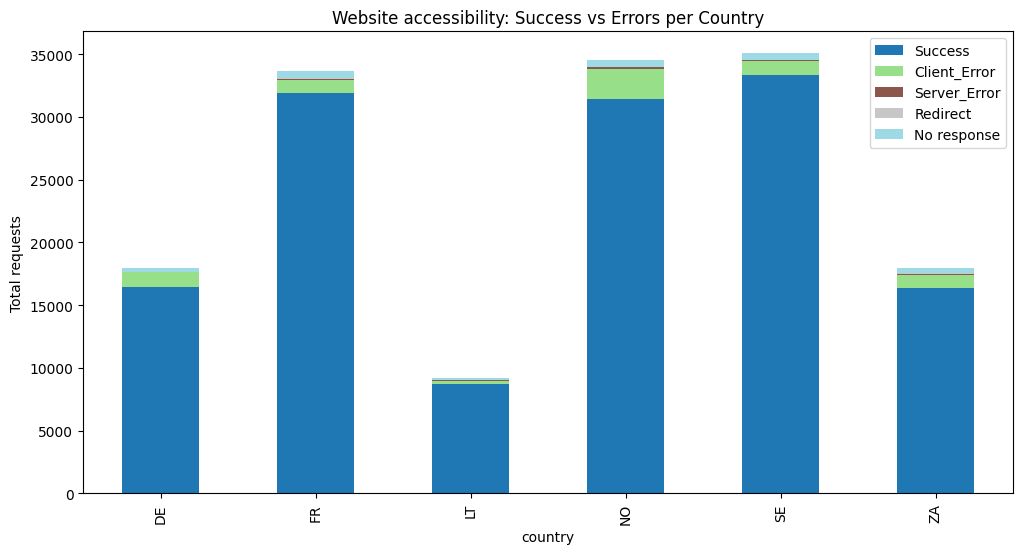

In [167]:
country_errors[['Success','Client_Error','Server_Error','Redirect', 'No response']].plot(
    kind='bar', stacked=True, figsize=(12,6), colormap='tab20'
)
plt.ylabel('Total requests')
plt.title('Website accessibility: Success vs Errors per Country')
plt.show()


In [178]:
status_cols = ['0','200','202','206', '301', '302', '400', '403', '404',
               '429', '475', '500', '502', '503', '504', '511', '522']


def compute_status_code_percentages(df, group_col, status_cols):
    grouped = df.groupby(group_col)[status_cols].sum()
    totals = grouped.sum(axis=1)
    percent = grouped.div(totals, axis=0) * 100
    percent["TotalChecks"] = totals

    return percent


def plot_status_heatmap(percent_df, title, sort_by="200", ascending=True):
    percent_df = percent_df.sort_values(sort_by, ascending=ascending)
    plt.figure(figsize=(14, 8))
    
    sns.heatmap(
        percent_df.drop(columns=["TotalChecks"]),  
        annot=True,
        fmt=".1f",
        cmap="viridis",
        linewidths=0.4
    )
    
    plt.title(title, fontsize=14)
    plt.xlabel("Status Code")
    plt.ylabel(percent_df.index.name.capitalize())
    plt.tight_layout()
    plt.show()


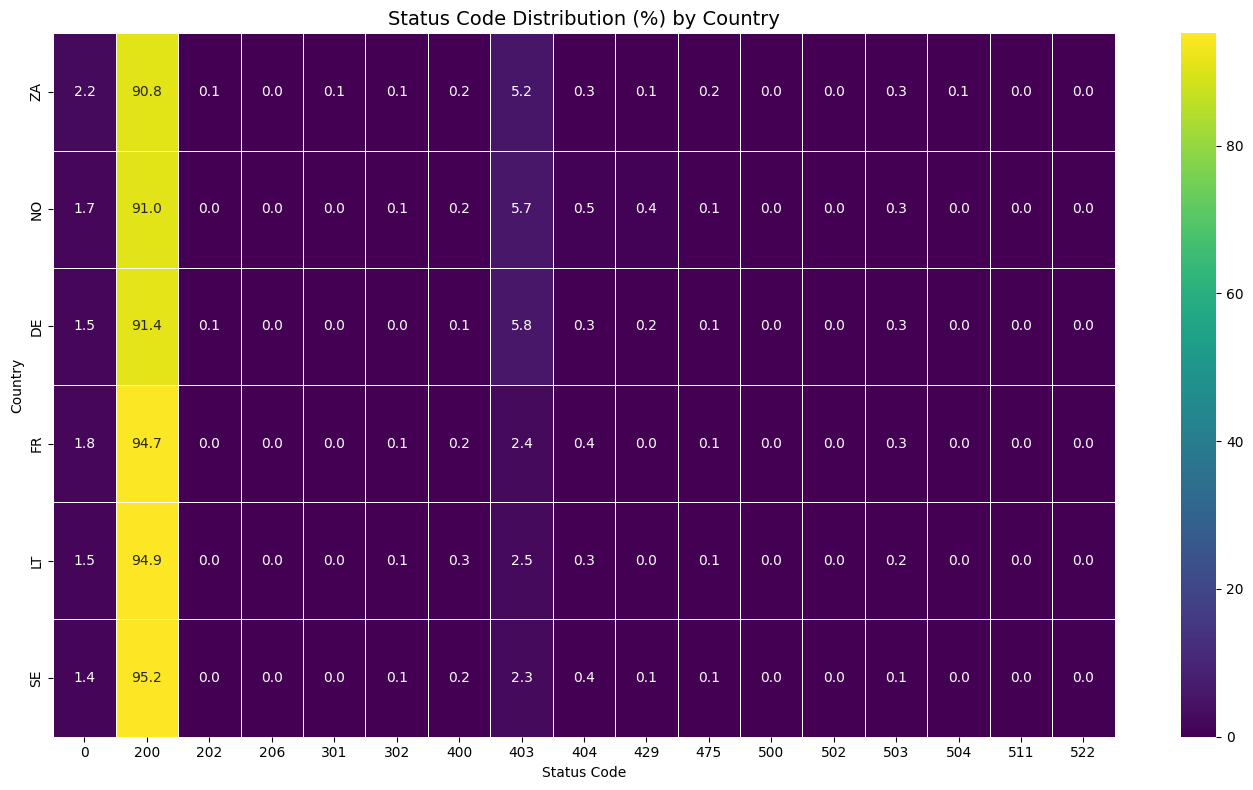

In [179]:
country_status = compute_status_code_percentages(merged_df, "country", status_cols)
plot_status_heatmap(country_status, "Status Code Distribution (%) by Country")


We observe that the highest percentage of errors belongs to 403 code which means "Forbidden" and this could be interpreted as VPN blocked / region blocked. This pattern shows up consistently for the all observed countries in our data. The highest 403 code percentage is for Germany (5.8%) and Norway (5.7%). The highest "No response" ("0") compare to the other observed countries is for South Africa (2.2%). 

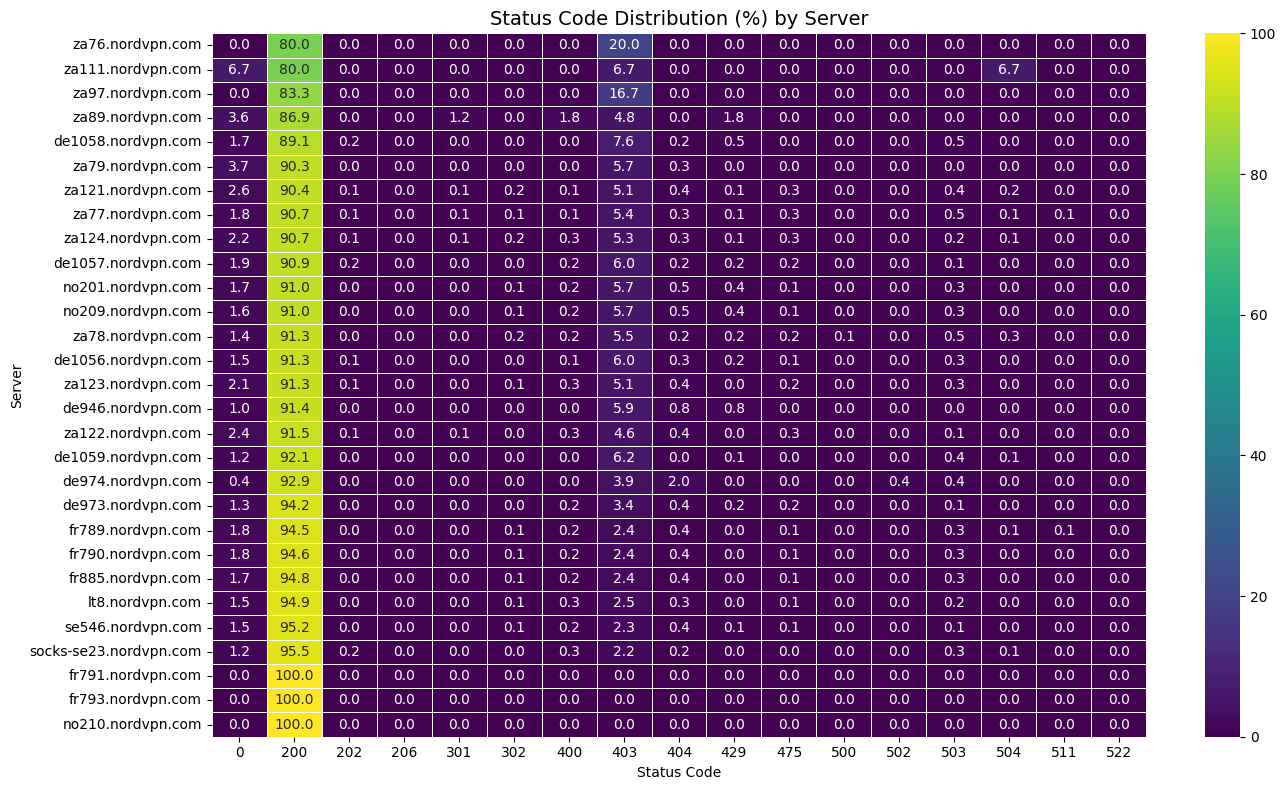

In [180]:
server_status = compute_status_code_percentages(merged_df, "server", status_cols)
plot_status_heatmap(server_status, "Status Code Distribution (%) by Server")

We observe that some South Africa servers (za76, za111, za97) have smaller success rate compare to the other servers. 

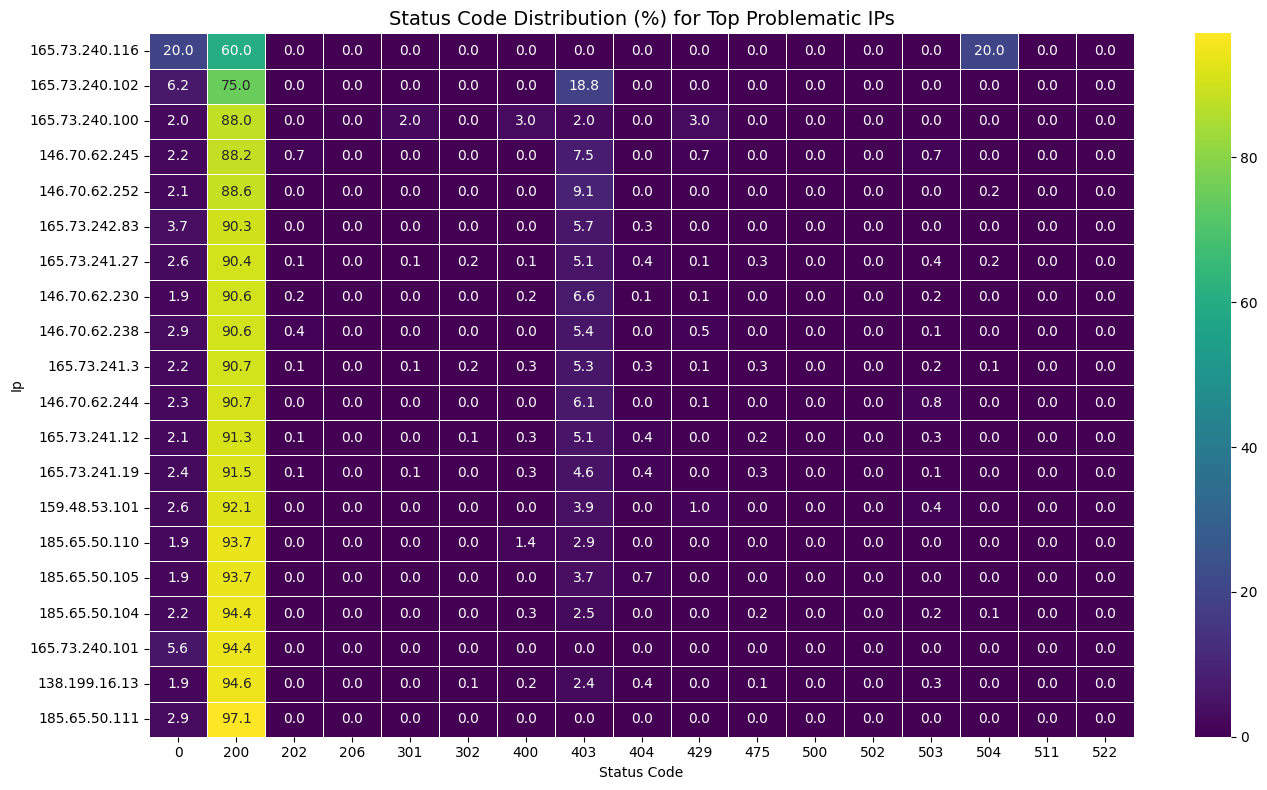

In [181]:
ip_status = compute_status_code_percentages(merged_df, "ip", status_cols)

# Take top 40 most problematic IPs
top_ip = ip_status.sort_values("0", ascending=False).head(20)

plot_status_heatmap(top_ip, "Status Code Distribution (%) for Top Problematic IPs")


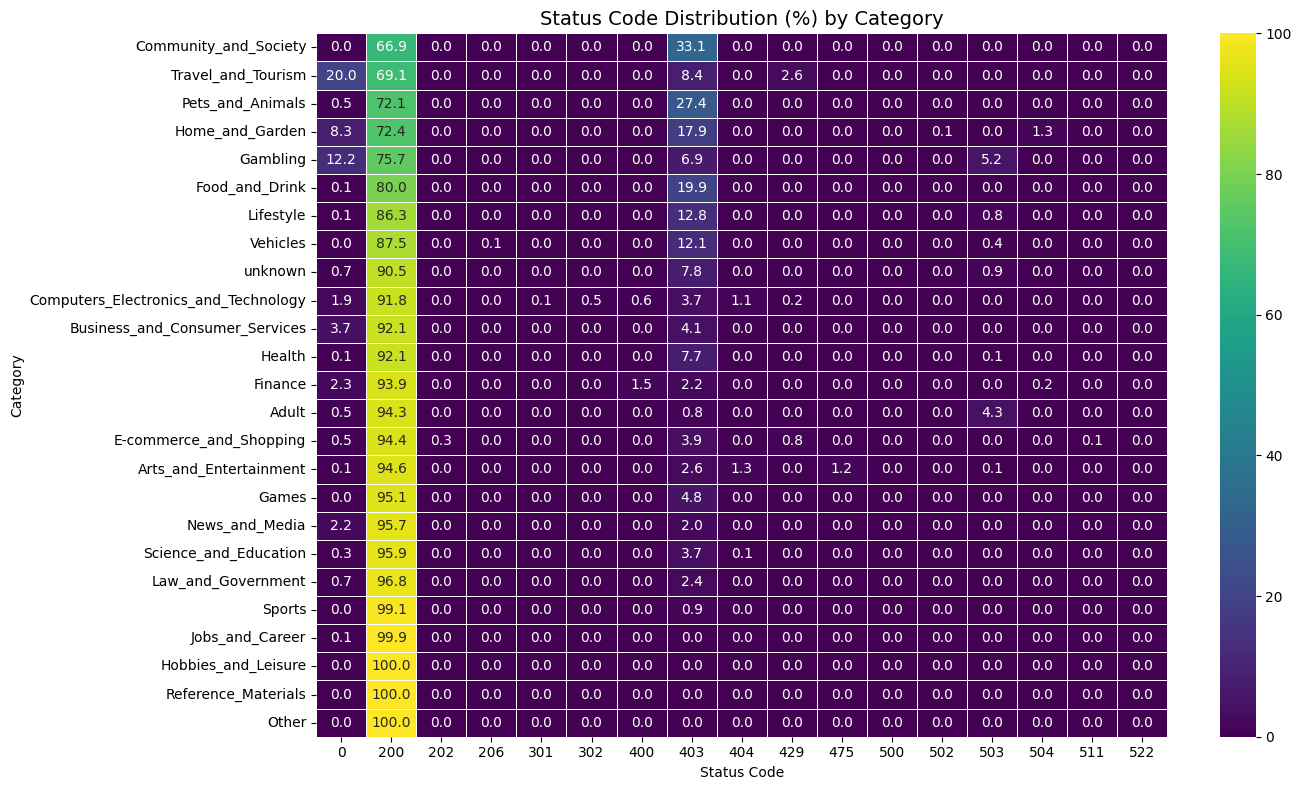

In [182]:
category_status = compute_status_code_percentages(merged_df, "category", status_cols)
plot_status_heatmap(category_status, "Status Code Distribution (%) by Category")


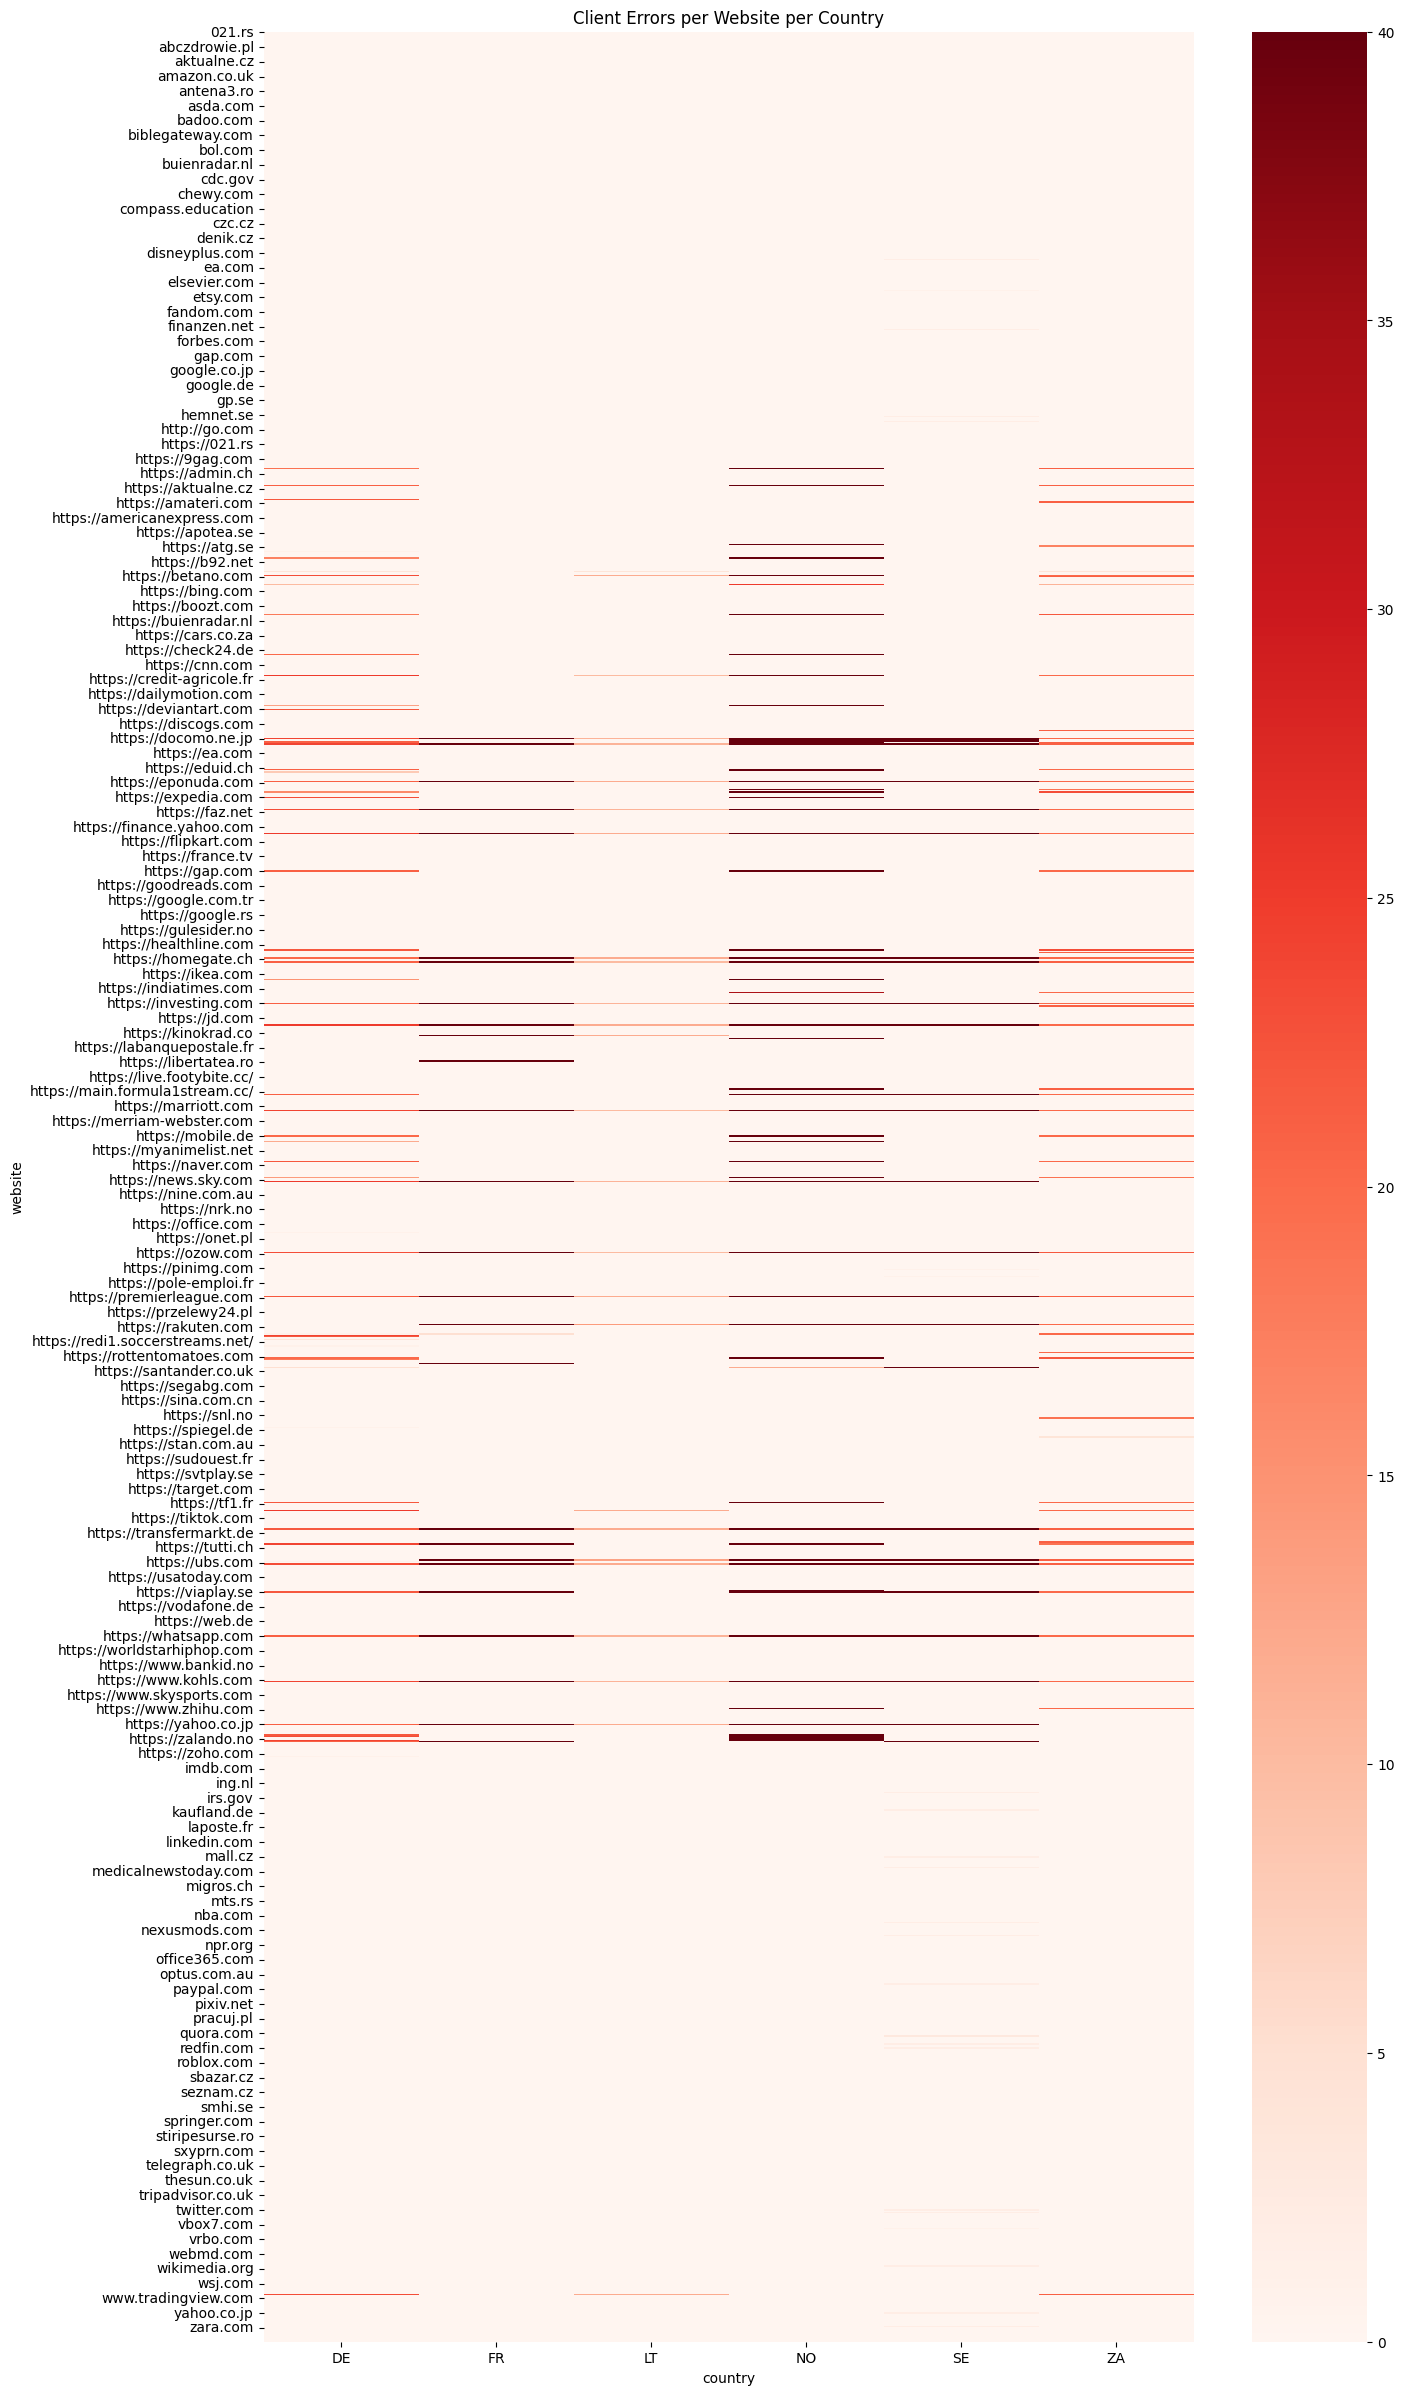

In [185]:
bywebsites_data = merged_df.pivot_table(
    index='website',
    columns='country',
    values='Client_Error',  # or 'Server_Error', 'Success'
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(15,30))
sns.heatmap(bywebsites_data, cmap='Reds')
plt.title('Client Errors per Website per Country')
plt.show()


# Task 3:Typically, a website is deemed accessible when the HTTP status response code is “200.” Based on this information, how would you assess website accessibility? Do you believe the assumption that a website is accessible only when the HTTP status code is “200” is accurate? Additionally, which website categories are the most and least accessible, and what are their respective accessibility rates?  

The assumption that a website is accessible only when the HTTP response is 200 is technically incomplete.
Many websites legitimately return other success codes such as 202 (accepted), 206 (partial content), 301 (permanent redirect), or 302 (temporary redirect).
Using only 200 would underestimate accessibility, especially for websites that rely heavily on redirects or partial content.
A better approach is to treat all 2xx and 3xx codes as successful accessibility, and mark only 4xx, 5xx and timeouts (0, 522) as failures.

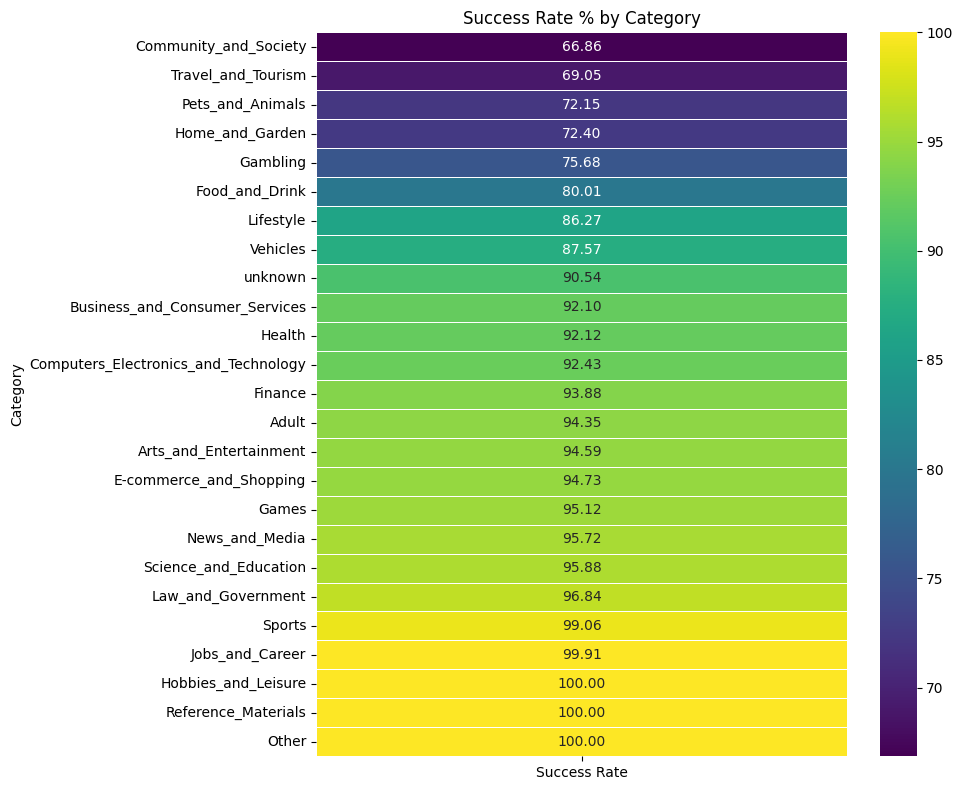

In [ ]:
status_cols = [c for c in merged_df.columns if c.isdigit()]
success_codes = ['200','202','206', '301','302']   
merged_df['Success'] = merged_df[success_codes].sum(axis=1)
all_codes = status_cols 
merged_df['TotalChecks'] = merged_df[all_codes].sum(axis=1)


success_by_category = merged_df.groupby('category')[['Success', 'TotalChecks']].sum()

success_by_category['Success Rate'] = (success_by_category['Success'] /success_by_category['TotalChecks']) *100
category_success_sorted = success_by_category.sort_values("Success Rate", ascending=True)


plt.figure(figsize=(10, 8))

sns.heatmap(
    category_success_sorted[["Success Rate"]],
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.5
)

plt.title("Success Rate % by Category")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


If we apply the new calculation logic, categories: Other, Reference Materials, Hobies and Leisure were the most accessible (100%) and categories: Community and Society (66.86%), Travel and Tourism (69.05%) were the least accessible. 

# Task 4: If you had to select a single visualization for the meeting to represent website accessibility, which metrics, variables, and type of visualization would you choose? Please explain your reasoning and prepare the visualization.



# Task 5:  When creating a weekly report on website accessibility, what specific information and metrics would you include? In which order? Please explain your decision.

I would construct this kind of flow: “What’s happening?” → “Where?” → “Why?” → “What do we do about it?”
I would start with high-level insights for executives who want to see is the situation improving or worsening, is user pain increasing, what requires attention?
Would include:
Overall accessibility rate (global)
Week-over-week change 
Top 3 most affected website categories
Top 3 worst-performing countries/regions
Any major outages/incidents (e.g., many services blocking VPN IPs)
Any improvements (new IP pools, routing fixes)


Then present big-picture metrics - this grounds the reader in data before diving into specifics.
Metrics:
Overall accessibility rate = accessible / total checks
Failure rate, broken down by:
Block errors (403, 475)
Rate limits (429)
Timeouts (0, 522)
Server errors (500/502/503/504)
Coverage: number of websites and countries monitored
Top-1000 website accessibility rate vs. non-top-1000
Include week-over-week % delta for each metric.

Then follow with the most actionable breakdowns. 
Country→ IP pool problems
Metrics per region:
Accessibility rate
Failure breakdown
Worst 5 websites in that region
Comparison vs. last week

Number of servers/IPs with elevated failures (possible IP blacklisting)
Category → user scenario problems
Metrics:
Accessibility rate
Total checks
Failure breakdown
Week-over-week trend
Top 3 websites causing issues
Categories with significant deterioration or improvement

Website → highly visible issues
Worst 10 Websites of the Week (Global), for each of the top 10:
Accessibility rate
Total checks
Worst region
Dominant error code
Trend vs last week
Category + top-1000 flag

Server/IP → operational fixes
Metrics per server/IP:
Accessibility rate
Number of websites affected
Dominant error type
Trend vs last week
Comparison to other servers in same region

Finally would end up with the details that only technical stakeholders need them. 

# Task 6: What additional data could enhance this analysis? What value it would bring? Would you recommend adding publicly available datasets, and if so, why?

Additionally it would be beneficial to have: timestamped monitoring logs  -  now I only see totals per status code after aggregation, I cannot analyze time-based patterns. This data would help detect peak-time failures, identify routing outages (hourly/daily spikes), correlate failures with server load, identify intermittent blocking vs permanent blocking, improve incident detection. 
Also Server Load & Network related data (CPU load, Network throughput),  this could help distinguish between website-side blocks and node-side congestion, explains spikes in 5XX errors, helps optimize routing and load balancing. 
User Complaint Metadata: complaints per website, per region, complaint timestamps, correlation to VPN server usage. This could help conduct better prioritization knowing clear user pain: verify whether a monitored failure actually affects users, helps PM judge user impact and allocate resources.
Website Traffic Weighting (if provided the top list was not in NordSecurity top, but worldwide): If you know which websites are popular among your users, you can weight accessibility rates. This gives realistic view of user impact, Prevents obscure websites from skewing results, highlights major-user-path failures. 

Public data sources to add:
IP reputation lists to identify VPN-blocking websites;
Some data to understand geo-specific blocks;
Global performance data to distinguish VPN vs global outages;
Geo-restriction/legal data to explain expected blocks;
Internet outage feeds to reduce false positives;
Adding public datasets such as IP reputation feeds, geo-restriction data, and global outage data helps contextualize failures and prevent misinterpretation. This improves accuracy, reduces false alarms, and enables smarter decisions about routing, IP rotation, and communication with users.
